In [ ]:
%pip install -U gym[atari,accept-rom-license]

%pip install -U gym[atari,accept-rom-license]

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!ls gdrive/'My Drive'/Ms-Pacman-V0

In [5]:
import gym
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
import random
import datetime

In [6]:
reward_number = 0.37

In [7]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.convolution1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.convolution2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5)
        self.convolution3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7)
        self.fc1 = nn.Linear(in_features=1792, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=256)
        self.fc4 = nn.Linear(in_features=256, out_features=32)
        self.fc5 = nn.Linear(in_features=32, out_features=9)

    def forward(self, x):
        x = x.cuda()
        x = F.relu(F.max_pool2d(self.convolution1(x), 3))
        x = F.relu(F.max_pool2d(self.convolution2(x), 3))
        x = F.relu(F.max_pool2d(self.convolution3(x), 3, 2))
        x = x.reshape(x.size(0), - 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [8]:
model = CNN()

In [9]:
model = model.cuda()

In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)



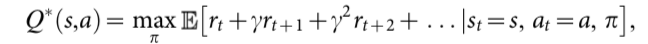

In [11]:
class DQNAgent:
    def __init__(self, action_size = 9):
        self.state_size = 4
        self.action_size = action_size
        self.memory_n = deque(maxlen=2000)
        self.memory_p = deque(maxlen=2000)
        self.gamma = 1.0    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.5
        self.epsilon_decay = 0.995
        self.learning_rate = 0.1
        self.model = model

    def remember(self, state, action, reward, next_state, done):
        if reward == 0:
            self.memory_p.append((state, action, reward, next_state, done))
        else:
            self.memory_n.append((state, action, reward, next_state, done))
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state_tensor = torch.from_numpy(state).float()
        act_values = self.model(state_tensor).cpu().detach().numpy()
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        if len(agent.memory_n) > batch_size / 2:
            print("Negative batch ready:")
            minibatch_n = random.sample(self.memory_n, 5)
            minibatch_p = random.sample(self.memory_p, 59)
            minibatch = random.sample((minibatch_p+minibatch_n), batch_size)
        else:
            minibatch = random.sample(self.memory_p, batch_size)
        for state, action, reward, next_state, done in minibatch:
            # reward = 0.001 if reward == 0 else 0.001
            ns_model = self.model(torch.from_numpy(next_state).float()).cpu().detach().numpy()
            if reward == 0:
                reward = 1.0001
                # print("Reward:", reward)
                target = reward * np.amax(ns_model[0])
                # print("target: ", target)
                target_f = ns_model
                # print("target_f: ", target_f)
                # print('Argmax: ', np.argmax(ns_model[0]))
                target_f[0][np.argmax(ns_model[0])] = target
                # print("target_f[0][np.argmax(ns_model[0])]: ", target_f)
            else:
                reward = reward_number
                # print("Reward:", reward)
                target = reward * np.amin(ns_model[0])
                # print("target: ", target)
                target_max = 0.0001 * np.amax(ns_model[0])
                # print("target_max: ", target_max)
                target_f = ns_model
                # print("target_f: ", target_f)
                target_f[0][action] = target
                target_f[0][random.choice([i for i in range(0,9) if i not in [action]])] = target_max
                # print("target_f[0][several actions]: ", target_f)
            self.train(next_state, target_f, epochs=1)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self, input, target, epochs = 1):
        input = torch.from_numpy(input).float().cuda()
        target = torch.from_numpy(target).float().cuda()
        y_pred = 0
        for t in range(1):
            y_pred = model(input)
            loss = - criterion(y_pred, target)
            # print(t, loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def load_all(self, name):
        loaded = torch.load(name)
        self.memory_n = loaded['memory_n']
        self.memory_p = loaded['memory_p']
        self.model.load_state_dict(loaded['state'])

    def save_all(self, name):
        torch.save({'state': self.model.state_dict(),
                    'memory_n': self.memory_n,
                    'memory_p': self.memory_p
                   }, name)

    def load(self, name):
        self.model.load_state_dict(torch.load(name))

    def save(self, name):
        torch.save(self.model.state_dict(), name)




In [17]:
env = gym.make('MsPacman-v0')
state_size = env.observation_space.shape
action_size = env.action_space.n


In [37]:
env

<OrderEnforcing<PassiveEnvChecker<AtariEnv<MsPacman-v0>>>>

In [18]:
agent = DQNAgent()

In [19]:
done = False
batch_size = 32


In [32]:
EPISODES = 5
for e in range(EPISODES):
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    vw = cv2.VideoWriter('gdrive/My Drive/Colab Notebooks/Pacman/' + "Reward_number_" + str(reward_number) + "_" + str(e) + str(datetime.datetime.now()) +  '.avi', fourcc, 4, (160,210))
    state = env.reset()
    state = np.reshape(state[0], (1, 210,160,3)).transpose(0,3,1,2)/255
    for time in range(1000000000):
        print(time)
        action = agent.act(state)
        next_state, reward, done, truncated, _ = env.step(action)
        vw.write(next_state)
        reward = reward if not done else 10
        reward = reward if reward ==0 else 10
        if reward != 0:
            print("ATTENTION NEGATIVE REWARD",reward)
        next_state = np.reshape(next_state, (1, 210,160,3)).transpose(0,3,1,2)/255
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            vw.release()
            agent.save('gdrive/My Drive/Colab Notebooks/Pacman/' + "Reward_number_" + str(reward_number) + "_""Frames:_" + str(time) + "_Episode_" +str(e) + "_Date_" + str(datetime.datetime.now()) + '.pt')
            print("episode: {}/{}, score: {}, e: {:.2}".format(e+1, EPISODES , time, agent.epsilon))
            break
        if (len(agent.memory_p) > batch_size) & (len(agent.memory_n) > batch_size/2) :
            agent.replay(batch_size)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
110
Negative batch ready:
111
ATTENTION NEGATIVE REWARD 10
Negative batch ready:
112
Negative batch ready:
113
Negative batch ready:
114
Negative batch ready:
115
Negative batch ready:
116
Negative batch ready:
117
Negative batch ready:
118
Negative batch ready:
119
Negative batch ready:
120
Negative batch ready:
121
Negative batch ready:
122
Negative batch ready:
123
Negative batch ready:
124
Negative batch ready:
125
Negative batch ready:
126
Negative batch ready:
127
Negative batch ready:
128
ATTENTION NEGATIVE REWARD 10
Negative batch ready:
129
Negative batch ready:
130
Negative batch ready:
131
Negative batch ready:
132
Negative batch ready:
133
Negative batch ready:
134
Negative batch ready:
135
ATTENTION NEGATIVE REWARD 10
Negative batch ready:
136
Negative batch ready:
137
Negative batch ready:
138
Negative batch ready:
139
Negative batch ready:
140
Negative batch ready:
141
Negative batch ready:
142
Negative batch ready

In [34]:
agent.load('/content/gdrive/MyDrive/Colab Notebooks/Pacman/Reward_number_0.37_Frames:_936_Episode_0_Date_2024-09-23 04:58:32.652282.pt')

<ipython-input-11-39c62ff51b22>:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(name))


In [35]:
!ls 'gdrive/My Drive/Colab Notebooks/Pacman/'

'Reward_number_0.37_02024-09-23 04:56:05.027275.avi'
'Reward_number_0.37_12024-09-23 04:58:32.672566.avi'
'Reward_number_0.37_22024-09-23 05:01:12.755640.avi'
'Reward_number_0.37_32024-09-23 05:02:48.711474.avi'
'Reward_number_0.37_42024-09-23 05:05:53.201287.avi'
'Reward_number_0.37_Frames:_1018_Episode_1_Date_2024-09-23 05:01:12.737450.pt'
'Reward_number_0.37_Frames:_1174_Episode_3_Date_2024-09-23 05:05:53.183557.pt'
'Reward_number_0.37_Frames:_613_Episode_2_Date_2024-09-23 05:02:48.694658.pt'
'Reward_number_0.37_Frames:_744_Episode_4_Date_2024-09-23 05:07:50.374261.pt'
'Reward_number_0.37_Frames:_936_Episode_0_Date_2024-09-23 04:58:32.652282.pt'
